# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 69

## Student 1 
### Name : Konrad Ponichtera
### ID : 5580749

## Student 2
### Name : Ion Babalau
### ID : 5626110

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nbformat

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import SGDClassifier

In [2]:
nb = nbformat.read("Lab4.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 297


## README

Expected location of dataset: _data_ directory, in same directory as notebook. 

All the necessary packages are specifeid in _requirements.txt_, and can be installed with the command: `pip install -r requirements.txt`.

## 1. Preparation (0 points)

### 1a. Load the dataset and split it into a train and test set

In [3]:
X = np.load('data/X.npy')
y = np.load('data/y.npy')

In [4]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,22751,22752,22753,22754,22755,22756,22757,22758,22759,22760
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30392,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
30393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30394,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Training logistic regression model before attacking

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3015
           1       0.91      0.93      0.92      3065

    accuracy                           0.92      6080
   macro avg       0.92      0.92      0.92      6080
weighted avg       0.92      0.92      0.92      6080

Accuracy: 91.90789473684211


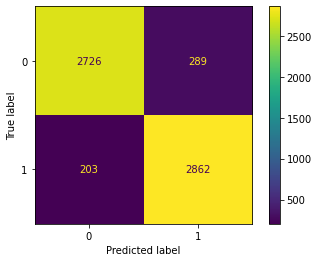

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

clf = SGDClassifier(loss='log', random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

y_predictions = clf.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [6]:
def evade(sample, coef):
    result = sample.copy()
    for i in range(len(result)):
        if coef[i] < 0:
            result[i] = 1
    return result

In [7]:
X_attack = X_test.copy()

coef = clf.coef_[0]

for i in range(len(X_attack)):
    if y_test[i] == 1:
        X_attack[i] = evade(X_attack[i], coef)


              precision    recall  f1-score   support

           0       0.47      0.90      0.62      3015
           1       0.00      0.00      0.00      3065

    accuracy                           0.45      6080
   macro avg       0.24      0.45      0.31      6080
weighted avg       0.23      0.45      0.31      6080

Accuracy: 44.83552631578947


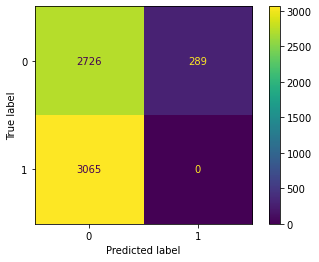

In [8]:
y_predictions = clf.predict(X_attack)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

### 2b. Analysis and answers to the questions

The implemented evasion attack adds useless import whevever the value of the linear model's coefficient is smaller than zero.
Applying it to the malicious examples from the test data manages to significantly decrease the overall accuracy of the model, leading to all the malicious examples being classified as benign.
This means that the model is not robust against adding useless imports - especially if the values of the model's coefficients are known to the attacker.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

X_train_attack = []
y_train_attack = []

for i in range(len(X_train)):
    if y_train[i] == 1:
        X_train_attack += [evade(X_train[i], coef)]
        y_train_attack += [1]

In [20]:
clf = SGDClassifier(loss='log', random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
clf.partial_fit(X_train_attack, y_train_attack)

SGDClassifier(loss='log', n_jobs=-1, random_state=0)

              precision    recall  f1-score   support

           0       0.98      0.15      0.26      3015
           1       0.54      1.00      0.70      3065

    accuracy                           0.58      6080
   macro avg       0.76      0.57      0.48      6080
weighted avg       0.76      0.58      0.49      6080

Accuracy: 57.8453947368421


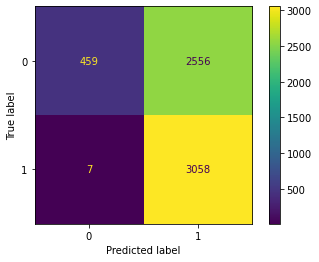

In [21]:
y_predictions = clf.predict(X_test)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

In [22]:
X_test_attack = X_test.copy()

for i in range(len(X_test_attack)):
    if y_test[i] == 1:
        X_test_attack[i] = evade(X_test_attack[i], coef)

              precision    recall  f1-score   support

           0       1.00      0.15      0.26      3015
           1       0.55      1.00      0.71      3065

    accuracy                           0.58      6080
   macro avg       0.77      0.58      0.48      6080
weighted avg       0.77      0.58      0.49      6080

Accuracy: 57.96052631578947


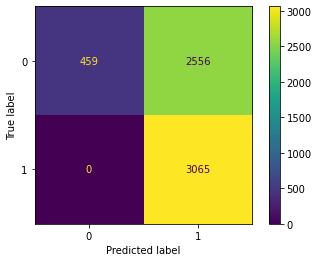

In [23]:
y_predictions = clf.predict(X_test_attack)

print(classification_report(y_test, y_predictions))
print(f"Accuracy: {accuracy_score(y_test, y_predictions) * 100}")

ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)
plt.show()

### 3b. Analysis and answers to the questions

Partially fitting the model with the training samples that had the evasion attack applied to them vastly increases the recall of the malicious class and classifies the malicious samples correctly even after applying the evasion attacks to them.
However, it also significantly decreases the precision and leads to majority of the benign samples being classified as malicious.

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

### 4b. Analysis and answers to the questions.